<img src="https://drive.google.com/uc?id=1dFgNX9iQUfmBOdmUN2-H8rPxL3SLXmxn" width="400"/>


---

created by **Jiashun Yao**

In [ ]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Afternoon Session 6: Wasserstein Generative Adversarial Networks with Gradient Penalty (WGAN-GP)

WGAN is a solution to the "hard to train" problem of GANs. Instead of optimising the J-S divergence between the $\mathbb P_{data}$ and $\mathbb P_G$, WGAN measures and optimises the "***Wasserstein distance***" between the two distributions.

This simple change of the loss function brings excellent properties:
* training process is more stable
* the loss value is more "meaningful" as an indicator of the quality of the generated data

![]()




<figure>
<center>
<img src='https://www.researchgate.net/profile/Soheil-Kolouri-2/publication/324246144/figure/fig6/AS:612260317777920@1522985643291/These-plots-show-W-1-p-q-t-and-JSp-q-t-where-p-is-a-uniform-distribution-around.png' />
<figcaption>These plots show W-distance and J-S divergence where p is a uniform distribution around zero and q τ (x) = p(x − τ). It is clear that JS divergence does not provide a usable gradient when distributions are supported on non-overlapping domains. (Kolouri et al, 2018)</figcaption></center> 
</figure>

### What is "Wasserstein distance":
* also called "Earth mover distance"
* Intuitively, imaging $\mathbb P_{data}$ and $\mathbb P_G$ to be two piles of soil, the Wasserstein distance is the minimum "cost" of moving one pile into the other.

## Math of the WGAN-GP
By defination:

$\mathbf W(\mathbb P_{data}, \mathbb P_G) = \inf_{\gamma \in \Pi(\mathbb P_{data}\, , \mathbb P_G)} \mathbb E_{(x, x_G)\sim \gamma} [ \| x - x_G \| ] - (1)$

Equation (1) says that:
1. from a joint distribution (of the real data and fake generated data) $\gamma$, we can sample a pair of real data sample $x$ and a fake data sample $x_G = G(z)$;
2. the distance between the two samples are $\| x - x_G \|$;
3. when enough samples from $\gamma$ are samples, we can estimate the expected value of the above distance under this joint distribution;
4. $\mathbf W(\mathbb P_{data}, \mathbb P_G)$ is defined as the infimum of such expected values over all possible joint distributions.

It is clear that this infimum is highly intractable -- we only have limited number of samples of $\mathbb P_{data}$ and $\mathbb P_G$.

Alternatively, according to the Kantorovich-Rubinstein duality (Arjovsky et al 2017), equation (1) can be changed into:

$\mathbf W(\mathbb P_{data}, \mathbb P_G) = \sup_{\| f \|_L \le 1} \mathbb E_{x \sim \mathbb P_{data} }[f(x)] - \mathbb E_{x_G \sim \mathbb P_G }[f(x_G)] - (2)$

where the supremum is over all the 1-Lipschitz functions f (i.e., the gradient norm $|f(x_1) - f(x_2)|/|x_1 - x_2| \le 1$ for any pairs of ($x_1, x_2$).

This duality is mportant because that such functions of $f$ in Equation (2) can be approximated using deep neural networks (our discriminator $D$), and the 1-Lipschitz requirement can be met during the training of $D$ using regularizations. The approximation of (2) can be written as (Gulrajani et al, 2017):

$\mathbf W(\mathbb P_{data}, \mathbb P_G) \approx \max \{\mathbb E_{x \sim \mathbb P_{data} }[D(x)] - \mathbb E_{x_G \sim \mathbb P_G }[D(x_G)] - \mu \mathbb E_{\hat x \sim \mathbb P_{\hat x}}[(\| \nabla_\hat{x} D(\hat x)\|_2 - 1]\} - (3)$

where the first two terms are simply from (2), but the newly added third term is to penalize the gradient norm (Gradient Penalty) to let it meet the 1-Lipschitz continuity requirement. $\mu$ is a weightening factor for this term, $\hat x$ is a random linear interpolation between $x$ and $x_G$: 

$\hat x$ = $\epsilon x + (1-\epsilon x_G)$, where $\epsilon \sim U[0,1]$.

Once the network has been trained, the gradient with respect to the generator can be found by differentiating (2) with respect to generator $G$:

$\nabla_G W(\mathbb P_{data}, \mathbb P_G) = -\nabla_G D(G(z))$

## Algorithm of the WGAN-GP
<figure>
<center>
<img src='https://miro.medium.com/max/1400/1*JnBQNCOJxa8w9YMc5YjoXQ.png' />
<figcaption>(Gulrajani et al, 2017)</figcaption></center> 
</figure>


For each training batch, this algorithm says below: 
1. get m samples from real data ($x\sim \mathbb P_{data}$);
2. get m samples from the latent space ($z \sim \mathbb P_{z}$), input them into generater to generate m fake samples $x_G = G(z)$; Now we have m pairs real and fake data;
3. generate a random number $\epsilon$ between 0 and 1 ($\epsilon \sim U[0,1]$);
4. compute m interpolated samples ($\hat x$) from the paired real and fake data: $\hat x = \epsilon x + (1-\epsilon)x_G$;
5. Construct the loss function for each paired data: $L = D(x_G) - D(x) + \lambda(\|\nabla_{\hat x} D(\hat x)\|_2 -1)^2$;
6. Train $D$ to minimise the loss for this batch $\frac{1}{m}\sum_{i=1}^m L^{i}$ (we flipped the sign of equation (3) so we do minimisation here);
7. Train $G$ to minimise $\frac{1}{m} \sum_{i=1}^m -D(G(z))$

Note: 
* $\lambda$ - the weight of the gradient penalty term
* $n_{critic}$ - in each batch, run $n_{critic}$ iterations for adversarial network, and 1 iteration for generator network 

#### A few imports before we get started

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import random 
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


### Mounting the google drive for later storage

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### Exercise: Implementing the WGAN-GP

In this session you will implement a WGAN-GP using the MNIST dataset.

Latent vector length: 100

Network G:
1. Layer 1: 100 -> 256 (100 is length of latent vector)
2. Layer 2: 256 -> 512
3. Layer 3: 512 -> 1024
4. Layer 4: 1024 -> 784 (size of a MNIST image)

Apply leaky_relu(alpha=0.2) activation functions for layers 1-3, and tanh to layer 4.
* Leaky_relu helps to mitigate Vanishing gradient problem

Network D:
1. Layer 1: 784 -> 1024 
2. Layer 2: 1024 -> 512 
3. Layer 3: 512 -> 256 
3. Layer 4: 256 -> 1


Apply leaky_relu(alpha=0.2) activation functions for layers 1-3, and ***no activation*** to layer 4. 


In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=28*28):
        super().__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim=28*28):
        super().__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return self.fc4(x)
    

# build model
G = Generator().to(device)
D = Discriminator().to(device)

Print $G$ and $D$

In [ ]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [ ]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

Loss and hyper-parameters:
* batch_size = 100
* learning_rate = 0.0002
* Optimisor -- Adam

* $\lambda$ = 10
* $n_{critic}$ = 5

In [ ]:
# define loss
criterion = nn.BCELoss() 
z_dim = 100
bs = 100
lambda_gp = 10
n_critic = 5

# optimizer
lr = 0.0002
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [ ]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)


## The trainining:

1. Train $D$, repeat for $n_{critic}$ iterations:
  * Sample $m$ latent samples $z$; and sample $m$ real data $x$
  * generate fake data $x_g = G(z)$
  * generate $\hat x$
    * sample $\epsilon \sim U[0,1]$
    * $\hat x = \epsilon x + (1-\epsilon) x_g$
  * construct the gradient penalty term $D_{gp} = (\| \nabla_{\hat x} D(\hat x) \|_2 -1)^2$
  * construct the loss for $D$ training: $L_D = D(x_g) - D(x) +\lambda D_{gp}$
  * update $D$ to minimise the loss $\frac{1}{m}L$
   
2. Train $G$:
  * Sample $m$ latent samples $z$
  * generate the fake image $x_g = G(z)$
  * construct the loss for $G$ training: $L_G = -D(x_G)$
  * update $G$ to minimise the loss $\frac{1}{m}L_G$

In [ ]:
def gp_term(x_real, x_fake):
    m = bs
    epsilon = torch.rand(m, 1).to(device)
    x_interp = (epsilon * x_real + (1 - epsilon) * x_fake).to(device)
    x_interp = Variable(x_interp, requires_grad = True) # so we can compute the grad
    D_interp = D(x_interp)
    
    grad_D_interp = autograd.grad(outputs = D_interp,
                 inputs = x_interp,
                 grad_outputs=torch.ones((bs, 1)).to(device),
                 create_graph=True, retain_graph=True, only_inputs=True)[0]
                 
    D_gp = (grad_D_interp.norm(2, dim=1) - 1) ** 2

    return D_gp

### Define the trianing processes

In [ ]:
def D_train(x, lambda_gp):
    #-------------- Function of the discriminator training -------------------#
    D.train()
    D_optimizer.zero_grad()

    # D_real 
    x_real = x.view(-1, 28*28)
    x_real= Variable(x_real.to(device))
    D_real = D(x_real)

    # D_fake
    # sample vector and produce generator output
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake = G(z)
    D_fake = D(x_fake)

    # D_gp
    D_gp = gp_term(x_real, x_fake)
    
    # combine the losses
    D_loss = D_fake.mean() - D_real.mean() + lambda_gp * D_gp.mean()

    # model update 
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()


In [ ]:
def G_train(x):
    #-------------- Function of the generator training -------------------#
    G.train()
    G_optimizer.zero_grad()

    # sample vector and produce generator output
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake = G(z)

    # D_output for x_fake
    D_output = D(x_fake)

    # G loss
    G_loss = - D_output.mean() 

    # model update 
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

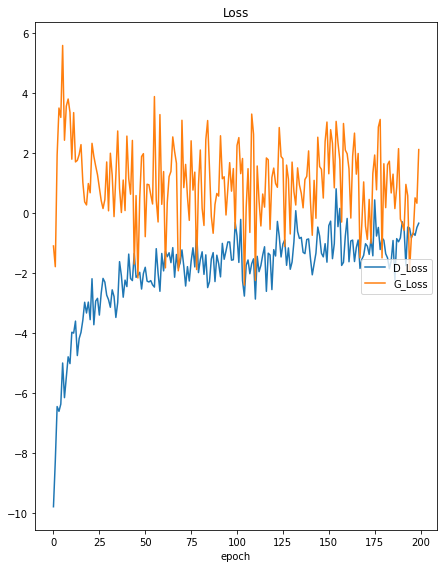

Loss
	D_Loss           	 (min:   -9.785, max:    0.820, cur:   -0.328)
	G_Loss           	 (min:   -2.389, max:    5.601, cur:    2.128)


In [ ]:
n_epoch = 200 # about 40 minutes
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):  
  D_losses, G_losses = [], []
  logs = {}
  
  for batch_idx, (x, _) in enumerate(train_loader):
    logs['D_Loss'] = D_train(x, lambda_gp) 
    if (batch_idx % n_critic == 0):
      logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

  # save every 20th epochs
  if(np.mod(epoch, 20) == 0):
    torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

### Sample random latent vectors, and input into generator to generate images.

Text(0.5, 1.0, 'Epoch = 020')

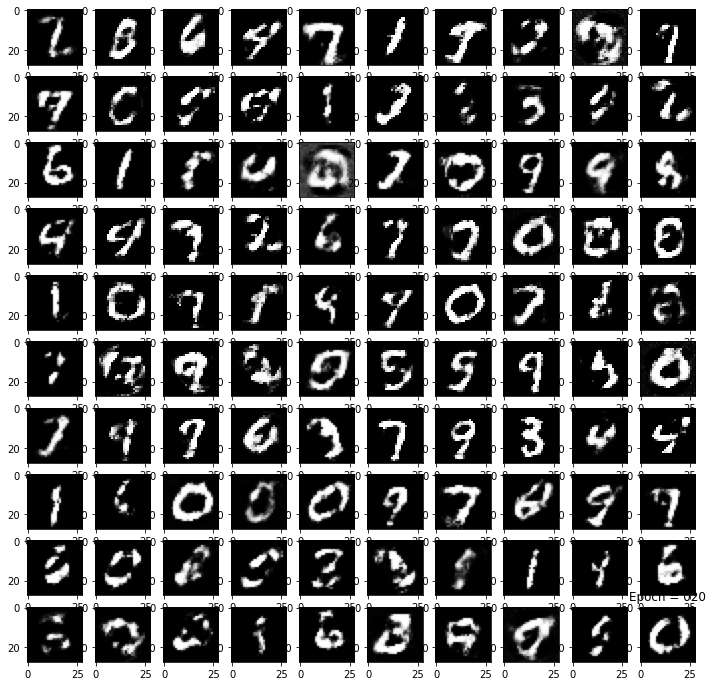

In [ ]:
# from torchvision.utils import save_image
set_seed(0)

epoch = 20
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 28, 28).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))

Text(0.5, 1.0, 'Epoch = 040')

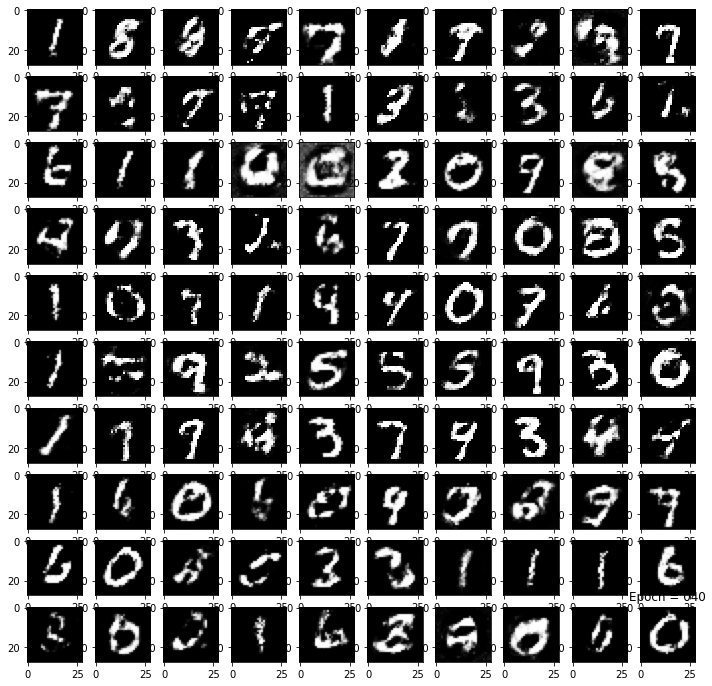

In [ ]:
# from torchvision.utils import save_image
set_seed(0)

epoch = 40
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 28, 28).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))

Text(0.5, 1.0, 'Epoch = 140')

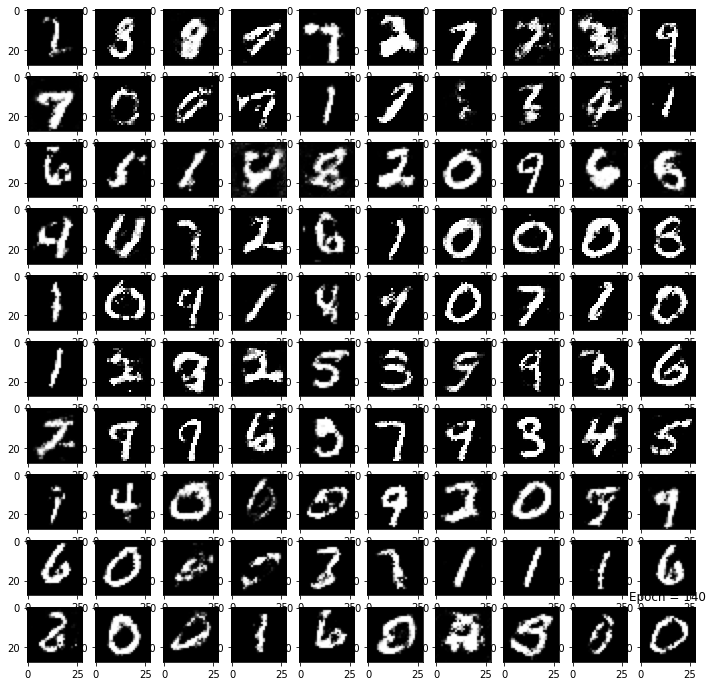

In [ ]:
# from torchvision.utils import save_image
set_seed(0)

epoch = 140
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 28, 28).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))

Text(0.5, 1.0, 'Epoch = 200')

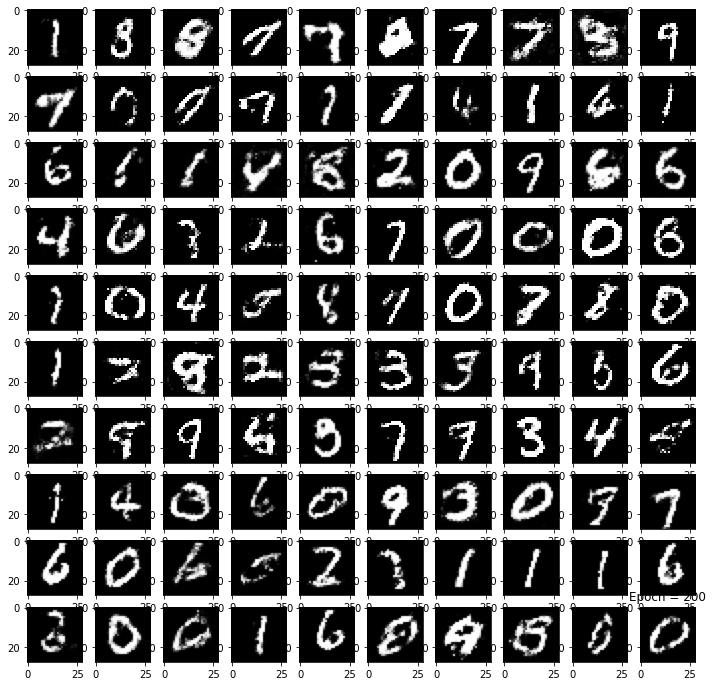

In [ ]:
# from torchvision.utils import save_image
set_seed(0)

epoch = 200
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 28, 28).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))